In [1]:
import os

import torch
import torch.nn as nn
from torch.autograd import Variable, grad
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torch.nn as nn
from PIL import Image
import numpy as np
import random
from tqdm import tqdm

import sys

import pickle
import argparse

In [2]:
import os

machine_path = os.getcwd()
user_root_dir = '/'.join(machine_path.split('/')[:-2])
sys.path.insert(0,'%s/redner/'%user_root_dir)
import pyredner

In [3]:
print('PyRedner location: %s'%pyredner.__file__)

# parser = argparse.ArgumentParser()
# parser.add_argument('--dataset_name', type = str, required = True)
# parser.add_argument('--model_files_pickle_name', type = str, required = True)
# args = parser.parse_args()

# DATASET_NAME = args.dataset_name
# MODEL_FILES_PICKLE_NAME = args.model_files_pickle_name

DATASET_NAME = "shapenet_illumination_and_camera_model"
MODEL_FILES_PICKLE_NAME = "categories_10_models_10.pkl"

SHAPENET_DIR = '%s/ShapeNetCore.v2'%user_root_dir

dataset_path = "%s/differentiable_graphics_ml/data/%s"%(user_root_dir, DATASET_NAME)
model_files_pickle_path = '%s/differentiable_graphics_ml/rendering/shapenet_model_subsets/%s'%(user_root_dir, MODEL_FILES_PICKLE_NAME)

if not os.path.isdir(dataset_path):
    print('This is a new dataset, creating a new folder at: %s'%dataset_path)
    os.mkdir(dataset_path)

PyRedner location: /net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/__init__.py


In [4]:
NUM_LIGHTS = 1

In [5]:
def get_light_positions(pos, num_lights):
    all_combinations = [[1,1,1],[-1,1,1],[1,-1,1],[1,1,-1],[1,-1,-1],[-1,1,-1],[-1,-1,1],[-1,-1,-1]]
    x,y,z = pos[0],pos[1],pos[2]
    if num_lights == 1:
        return [pos]
    else:
        chosen_combs = random.sample(all_combinations, num_lights-1)

        new_light_positions = [pos]
        for comb in chosen_combs:
            new_light_positions.append(torch.tensor([x*comb[0], y*comb[1], z*comb[2]]))
        return new_light_positions

def render_shapenet_obj(obj_path, camera_position, light_position, light_intensity, show_lights = False,render_seed = 1):
    obj_model_all = pyredner.load_obj(obj_path, return_objects=True)
    obj_model = [i for i in obj_model_all if len(i.vertices)>0]
    m = pyredner.Material(diffuse_reflectance = torch.tensor((0.8, 0.8, 0.8), device = pyredner.get_device()))
    for part in obj_model:
        part.material = m

    scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (224, 224))
    scene_cam.position = camera_position
    
    all_light_positions = get_light_positions(light_position, NUM_LIGHTS)
    scene_lights = []
    
    for l_pos in all_light_positions:
        scene_light = pyredner.generate_quad_light(position = l_pos,
                                         look_at = torch.zeros(3),
                                         size = torch.tensor([0.5, 0.5]),
                                         intensity = light_intensity,
                                         directly_visible = show_lights)
        scene_lights.append(scene_light)
        
    all_objects = obj_model + scene_lights
    scene = pyredner.Scene(objects = all_objects, camera = scene_cam)
    img = pyredner.render_pathtracing(scene,num_samples=256,seed=render_seed)
    im = torch.pow(img.data, 1.0/2.2).cpu()
    im = im*255/torch.max(im)
    image = Image.fromarray(im.numpy().astype('uint8'))
    return image, torch.sum(im)

In [15]:
# def render_shapenet_obj_non_stochastic(obj_path, camera_position, all_light_positions, light_intensity, show_lights = False,render_seed = 1):
#     obj_model_all = pyredner.load_obj(obj_path, return_objects=True)
#     obj_model = [i for i in obj_model_all if len(i.vertices)>0]
#     m = pyredner.Material(diffuse_reflectance = torch.tensor((0.8, 0.8, 0.8), device = pyredner.get_device()))
#     for part in obj_model:
#         part.material = m

#     scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (512, 512))
#     scene_cam.position = camera_position

#     scene_lights = []

#     for l_pos in all_light_positions:
#         scene_light = pyredner.generate_quad_light(position = l_pos,
#                                          look_at = torch.zeros(3),
#                                          size = torch.tensor([0.5, 0.5]),
#                                          intensity = light_intensity,
#                                          directly_visible = show_lights)
#         scene_lights.append(scene_light)

#     all_objects = obj_model + scene_lights
#     scene = pyredner.Scene(objects = all_objects, camera = scene_cam)
#     img = pyredner.render_pathtracing(scene,num_samples=256,seed=render_seed)
#     im = torch.pow(img.data, 1.0/2.2).cpu()
#     im = im*255/torch.max(im)
#     image = Image.fromarray(im.numpy().astype('uint8'))
#     return image, im

# def generate_spherical_light_points(num_steps = 10, radius = 1):
#     xs = np.linspace(-1,1,num_steps)
#     ys = np.linspace(-1,1,num_steps)
#     zs = np.zeros((num_steps,num_steps))
#     zs_2 = np.zeros((num_steps,num_steps))

#     all_points = []

#     for i in range(len(xs)):
#         x_val = xs[i]
#         for j in range(len(ys)):
#             y_val = ys[j]
#             z_squared = 1 - x_val**2 - y_val**2

#             if z_squared < 0 :
#                 zs[i,j] = 0
#             else:
#                 zs[i,j] = np.sqrt(z_squared)
#                 zs_2[i,j] = -np.sqrt(z_squared)

#                 point_1 = [radius * x_val, radius * y_val, radius * zs[i,j]]
#                 point_2 = [radius * x_val, radius * y_val, radius * zs_2[i,j]]
                
# #                 if point_1[0] > 1 and point_1[1] > 1 and point_1[2] > 1:
#                 all_points.append(point_1)
                
#                 if zs[i,j] !=  0.0:
#                     all_points.append(point_2)
                    
#     return all_points

In [33]:
points = []
for i in range(10000):
    points.append(np.random.normal())

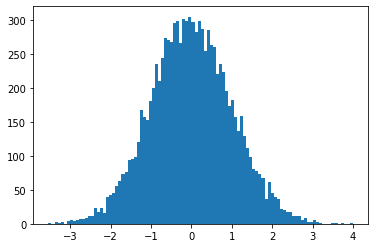

In [35]:
plt.hist(points,bins=100)
plt.show()

In [38]:
point

array([ 0.05935914, -0.20752042, -0.97642807])

In [46]:
def generate_uniform_on_sphere(num_points, radius):
    points = []
    for i in range(num_points):
        X = np.random.normal()
        Y = np.random.normal()
        Z = np.random.normal()

        vector = np.array([X,Y,Z])
        point = list(radius*vector/np.linalg.norm(vector))
        points.append(point)
    return points

In [47]:
sampled_points = generate_uniform_on_sphere(20,2)

In [8]:
# Simple scene setup
# cam_pos = torch.tensor([1.0,1.0,1.0])
light_intensity = torch.tensor([1.0,1.0,1.0])

In [9]:
# light_poses = [[.5, .5, -0.5], [1,1,1],[0.5,1,2],[0.5,1,0.5],[2.5,3,0.5],[3,4,0.3],[0.4,1,2.5],[4,4,4],[8,1,0.5]]

In [10]:
# model_files_pickle_path = '/om5/user/smadan/differentiable_graphics_ml/rendering/%s'%MODEL_FILES_PICKLE
with open(model_files_pickle_path, 'rb') as F:
    model_files = pickle.load(F)

sphere_light_poses = generate_spherical_light_points(5, 3)

In [11]:
# sphere_light_poses

In [12]:
# cam_pos = torch.tensor([1.0,1.0,1.0])

In [13]:
cam_pos_list = [[1.0,1.0,1.0],[0.0,1.0,1.414],[-1.0,1.0,1.0],[-1.414,1.0,0.0],
            [-1.0,1.0,-1.0],[0.0,1.0,-1.414],[1.0,1.0,-1.0],[1.414,1.0,0.0]]

In [33]:
dataset_path

'/net/coxfs01/srv/export/coxfs01/pfister_lab2/share_root/Lab/spandan/differentiable_graphics_ml/data/shapenet_illumination_and_camera_model'

In [34]:
dataset_path

'/net/coxfs01/srv/export/coxfs01/pfister_lab2/share_root/Lab/spandan/differentiable_graphics_ml/data/shapenet_illumination_and_camera_model'

In [35]:
cam_pos

tensor([1., 1., 1.])

In [39]:
# dataset_path

In [53]:
for category in sorted(model_files.keys()):
    category_dir = "%s/%s"%(SHAPENET_DIR, category)
    instance_model_files = model_files[category]
    for model_file in instance_model_files:
        model_file = model_file.replace('/om5/user/smadan',user_root_dir)
        instance = model_file.split('/')[-3]
        for cam_pos in cam_pos_list:
            for lp in cam_pos_list:
                cam_pos = torch.tensor(cam_pos)
                light_pos_list = [3*i for i in lp]
                light_pos = torch.tensor(light_pos_list).float()
                rendered_im, im_sum = render_shapenet_obj(model_file, cam_pos, light_pos, light_intensity, False,render_seed=1)
                image_name = "%s/%s_%s_%.03f_%.03f_%.03f_%.03f_%.03f_%.03f.png"%(dataset_path, category, instance, cam_pos[0].item(), cam_pos[1].item(), cam_pos[2].item(), light_pos[0].item(), light_pos[1].item(), light_pos[2].item())
                rendered_im.save(image_name)

100%|██████████| 10/10 [00:00<00:00, 46243.70it/s]


In [52]:
# for category in sorted(model_files.keys()):
#     category_dir = "%s/%s"%(SHAPENET_DIR, category)
#     instance_model_files = model_files[category]
#     for model_file in tqdm(instance_model_files):
#         print(model_file)
#         instance = model_file.split('/')[7]
#         for lp in sphere_light_poses:
#             light_pos = torch.tensor(lp).float()
#             rendered_im, im_sum = render_shapenet_obj(model_file, cam_pos, light_pos, light_intensity, False,render_seed=1)
#             image_name = "%s/%s_%s_%.03f_%.03f_%.03f.png"%(dataset_path, category, instance, light_pos[0].item(), light_pos[1].item(), light_pos[2].item())
#             rendered_im.save(image_name)